# Dataset Processing Demo: Light Source Removal, Positional/Velocity Encoding, and Dataset Modules

This notebook demonstrates:
1. **Light Source Reflection Removal** - Removing unwanted reflections from droplet images
2. **Positional Encoding** - Encoding spatial position information
3. **Velocity Encoding** - Encoding temporal/motion information
4. **Mother/Daughter Dataset Modules** - Understanding the dataset structure
5. **Dataset Caching** - Fast loading with pickle caching

---

## Setup and Configuration

In [4]:
# Import standard libraries
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import glob
os.chdir("..")  # Change to parent directory
# Add parent directory to path
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('__file__'))))

# Import custom modules
from dataset.light_source.LightSourceReflectionRemoving import LightSourceReflectionRemover
from dataset.positional_encoding.PositionalImageGenerator import PE_Generator
from dataset.MotherFolderDataset import MotherFolderDataset, dicLoader, split_dataset
from dataset.DaughterFolderDataset import DaughterFolderDataset

# Import utilities
import utils

print("✓ All modules imported successfully!")
print(f"NumPy version: {np.__version__}")
print(f"OpenCV version: {cv2.__version__}")

✓ All modules imported successfully!
NumPy version: 2.2.6
OpenCV version: 4.12.0


---

## 1. Load Sample Droplet Images

First, let's load some sample images from the dataset to work with.

In [5]:
# Define sample data path (adjust this to your actual data location)
DATA_ROOT = "/media/d25u2/Dont/Viscosity"

# Find a sample folder
sample_folders = glob.glob(os.path.join(DATA_ROOT, "280", "S5-*", "D*"))
if len(sample_folders) > 0:
    sample_folder = sample_folders[0]
    print(f"Using sample folder: {sample_folder}")
    
    # Load sample images
    cropped_folder = os.path.join(sample_folder, utils.config['cropped_image_folder'])
    sample_images = sorted(glob.glob(os.path.join(cropped_folder, "*.png")))[:5]
    
    print(f"Found {len(sample_images)} sample images")
    for i, img_path in enumerate(sample_images[:3]):
        print(f"  {i+1}. {os.path.basename(img_path)}")
else:
    print("⚠ No sample data found. Please adjust DATA_ROOT path.")
    sample_images = []

Using sample folder: /media/d25u2/Dont/Viscosity/280/S5-S60per_S10/D214048_07_10.15
Found 5 sample images
  1. frame_000173.png
  2. frame_000174.png
  3. frame_000175.png


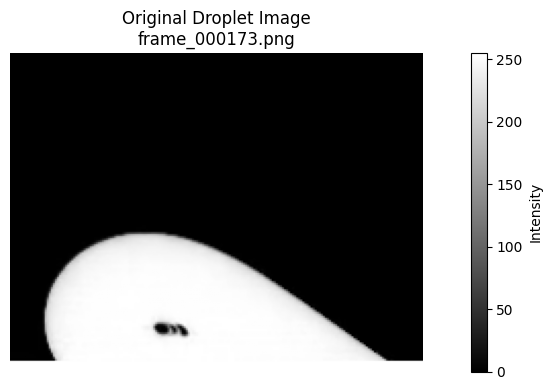

Image shape: (156, 202)
Data type: uint8
Value range: [0, 255]


In [6]:
# Load and display a sample image
if len(sample_images) > 0:
    sample_img = cv2.imread(sample_images[0], cv2.IMREAD_GRAYSCALE)
    
    plt.figure(figsize=(10, 4))
    plt.imshow(sample_img, cmap='gray')
    plt.title(f'Original Droplet Image\n{os.path.basename(sample_images[0])}')
    plt.colorbar(label='Intensity')
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    print(f"Image shape: {sample_img.shape}")
    print(f"Data type: {sample_img.dtype}")
    print(f"Value range: [{sample_img.min()}, {sample_img.max()}]")
else:
    print("No sample images available for display")

---

## 2. Light Source Reflection Removal

Droplet images often contain reflections from the light source that can interfere with analysis. Let's demonstrate the reflection removal algorithm.

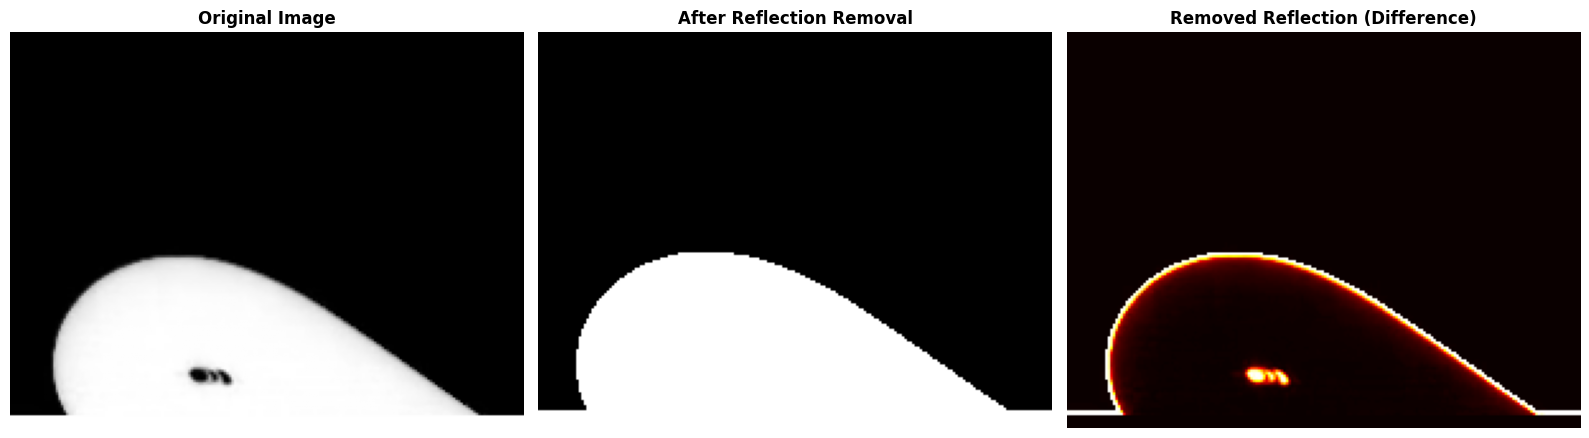

Original intensity range: [0, 255]
Cleaned intensity range: [0, 255]
Pixels modified: 6875 / 31512 (21.82%)


In [7]:
# Apply light source reflection removal
if len(sample_images) > 0:
    img_cleaned = LightSourceReflectionRemover(sample_img)
    
    # Visualize before and after
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))
    
    # Original
    axes[0].imshow(sample_img, cmap='gray')
    axes[0].set_title('Original Image', fontsize=12, fontweight='bold')
    axes[0].axis('off')
    
    # Cleaned
    axes[1].imshow(img_cleaned, cmap='gray')
    axes[1].set_title('After Reflection Removal', fontsize=12, fontweight='bold')
    axes[1].axis('off')
    
    # Difference
    difference = cv2.absdiff(sample_img, img_cleaned)
    axes[2].imshow(difference, cmap='hot')
    axes[2].set_title('Removed Reflection (Difference)', fontsize=12, fontweight='bold')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print(f"Original intensity range: [{sample_img.min()}, {sample_img.max()}]")
    print(f"Cleaned intensity range: [{img_cleaned.min()}, {img_cleaned.max()}]")
    print(f"Pixels modified: {np.sum(difference > 0)} / {difference.size} ({100*np.sum(difference > 0)/difference.size:.2f}%)")
else:
    print("No sample images available")

---

## 3. Positional Encoding

Positional encoding adds spatial position information to images, helping the model understand the droplet's location in the frame.

Positional encoding shape: (50, 640)
Value range: [0, 255]


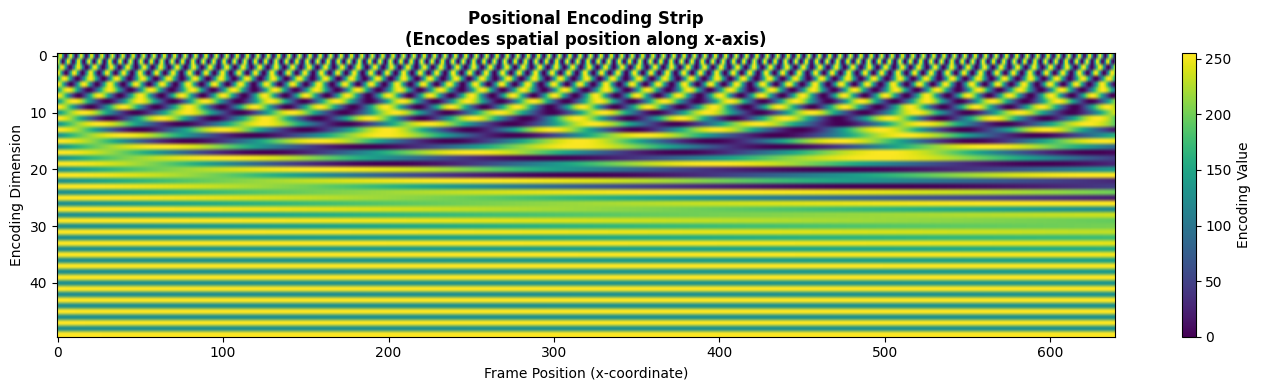

In [8]:
# Generate positional encoding
num_frames = 100  # Number of frames in sequence
PE_height = 50    # Height of the positional encoding strip
image_width = 640 # Width of images

# Create positional encoding
pe_positional = PE_Generator(
    num_frames,
    Resize=True,
    velocity_encoding=False,
    positional_encoding=True,
    PE_height=PE_height,
    default_image_size=(image_width, PE_height)
)

print(f"Positional encoding shape: {pe_positional.shape}")
print(f"Value range: [{pe_positional.min()}, {pe_positional.max()}]")

# Visualize the positional encoding
plt.figure(figsize=(14, 4))
plt.imshow(pe_positional, cmap='viridis', aspect='auto')
plt.title('Positional Encoding Strip\n(Encodes spatial position along x-axis)', 
          fontsize=12, fontweight='bold')
plt.xlabel('Frame Position (x-coordinate)')
plt.ylabel('Encoding Dimension')
plt.colorbar(label='Encoding Value')
plt.tight_layout()
plt.show()

---

## 4. Velocity Encoding

Velocity encoding captures temporal/motion information by encoding the rate of change across frames.

Velocity encoding shape: (50, 640)
Value range: [0, 255]


/tmp/ipykernel_25925/887224287.py:29: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


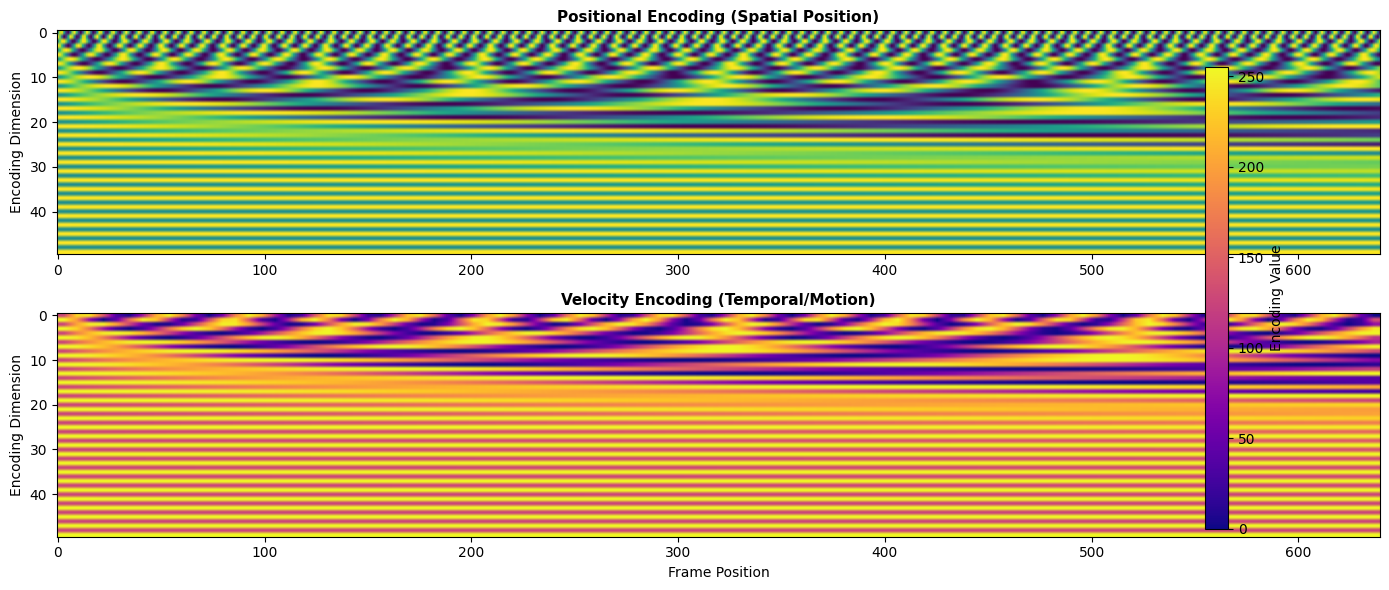


📊 Key Difference:
  • Positional: Encodes WHERE the droplet is in space
  • Velocity: Encodes HOW FAST the droplet is moving


In [9]:
# Generate velocity encoding
pe_velocity = PE_Generator(
    num_frames,
    Resize=True,
    velocity_encoding=True,
    positional_encoding=False,
    PE_height=PE_height,
    default_image_size=(image_width, PE_height)
)

print(f"Velocity encoding shape: {pe_velocity.shape}")
print(f"Value range: [{pe_velocity.min()}, {pe_velocity.max()}]")

# Visualize comparison
fig, axes = plt.subplots(2, 1, figsize=(14, 6))

# Positional encoding
axes[0].imshow(pe_positional, cmap='viridis', aspect='auto')
axes[0].set_title('Positional Encoding (Spatial Position)', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Encoding Dimension')

# Velocity encoding
im = axes[1].imshow(pe_velocity, cmap='plasma', aspect='auto')
axes[1].set_title('Velocity Encoding (Temporal/Motion)', fontsize=11, fontweight='bold')
axes[1].set_xlabel('Frame Position')
axes[1].set_ylabel('Encoding Dimension')

plt.colorbar(im, ax=axes, label='Encoding Value', fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

print("\n📊 Key Difference:")
print("  • Positional: Encodes WHERE the droplet is in space")
print("  • Velocity: Encodes HOW FAST the droplet is moving")

---

## 5. DaughterFolderDataset - Individual Experiment Loader

`DaughterFolderDataset` handles loading images from individual experiment folders (one fluid at different tilt angles).

In [10]:
# Create a DaughterFolderDataset from a small subset
if len(sample_folders) >= 2:
    daughter_dirs = sample_folders[:2]
    
    print("Creating DaughterFolderDataset with:")
    for i, d in enumerate(daughter_dirs):
        print(f"  {i+1}. {d}")
    
    daughter_dataset = DaughterFolderDataset(
        dirs=daughter_dirs,
        seq_len=3,  # Load sequences of 3 frames
        stride=5    # Every 5th frame
    )
    
    print(f"\n✓ DaughterFolderDataset created!")
    print(f"  Total samples: {len(daughter_dataset)}")
    print(f"  Sequence length: {daughter_dataset.seq_len}")
    print(f"  Stride: {daughter_dataset.stride}")
    
    # Load a sample
    if len(daughter_dataset) > 0:
        sample_seq, viscosity, drop_pos, srof, tilt = daughter_dataset[0]
        print(f"\n📦 Sample Data:")
        print(f"  Sequence shape: {sample_seq.shape}")  # (seq_len, channels, height, width)
        print(f"  Viscosity: {viscosity.item():.2f}")
        print(f"  Drop position: {drop_pos}")
        print(f"  SROF: {srof}")
        print(f"  Tilt angle: {tilt.item()}°")
else:
    print("⚠ Not enough sample folders for DaughterFolderDataset demo")
    daughter_dataset = None

Creating DaughterFolderDataset with:
  1. /media/d25u2/Dont/Viscosity/280/S5-S60per_S10/D214048_07_10.15
  2. /media/d25u2/Dont/Viscosity/280/S5-S60per_S10/D214048_05_10.15

✓ DaughterFolderDataset created!
  Total samples: 201
  Sequence length: 3
  Stride: 5

📦 Sample Data:
  Sequence shape: torch.Size([3, 1, 201, 201])
  Viscosity: 10.15
  Drop position: tensor([1026, 1199], dtype=torch.int16)
  SROF: tensor([[0.0000e+00, 5.4150e-01, 1.1512e+02, 3.3438e+01, 6.5430e-01, 1.0193e-01,
         5.9000e+01, 2.4391e+01],
        [2.5010e-04, 5.4785e-01, 1.1719e+02, 3.3812e+01, 6.5283e-01, 1.0187e-01,
         5.8969e+01, 2.4094e+01],
        [5.0020e-04, 5.5371e-01, 1.1531e+02, 3.2125e+01, 6.5527e-01, 1.0187e-01,
         5.8969e+01, 2.4250e+01]])
  Tilt angle: 80°


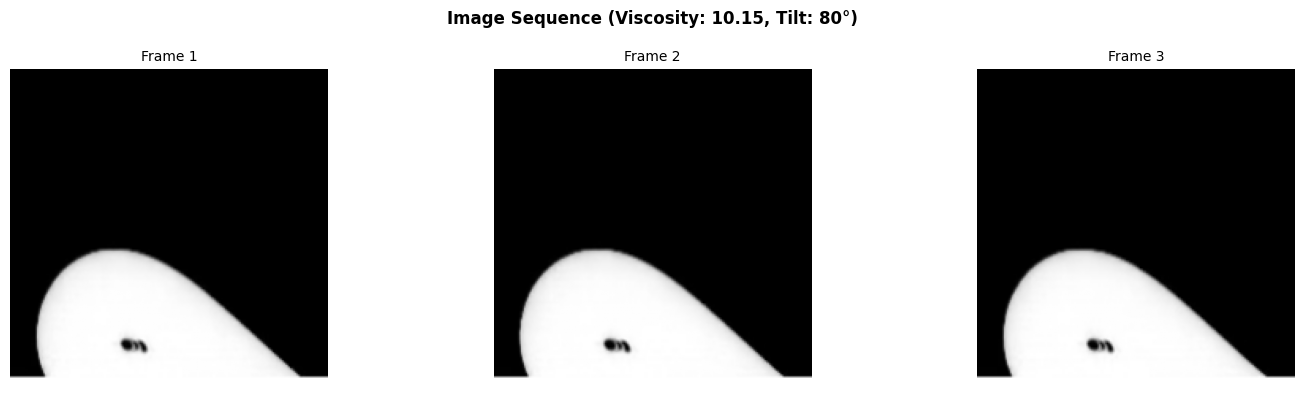

In [11]:
# Visualize a sequence from DaughterFolderDataset
if daughter_dataset is not None and len(daughter_dataset) > 0:
    sample_seq, viscosity, _, _, tilt = daughter_dataset[0]
    
    fig, axes = plt.subplots(1, sample_seq.shape[0], figsize=(15, 4))
    
    for i in range(sample_seq.shape[0]):
        frame = sample_seq[i, 0].numpy()  # Get i-th frame, channel 0
        axes[i].imshow(frame, cmap='gray')
        axes[i].set_title(f'Frame {i+1}', fontsize=10)
        axes[i].axis('off')
    
    fig.suptitle(f'Image Sequence (Viscosity: {viscosity.item():.2f}, Tilt: {tilt.item()}°)', 
                 fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.show()
else:
    print("No data available for visualization")

---

## 6. MotherFolderDataset - Complete Dataset Manager

`MotherFolderDataset` manages multiple fluids (each with multiple experiments) and provides:
- Automatic data balancing across fluids
- Normalized viscosity labels
- Train/val/test splitting

In [12]:
# Load dataset splits
try:
    dicAddressesTrain, dicAddressesValidation, dicAddressesTest = dicLoader(
        root=DATA_ROOT
    )
    
    print("✓ Dataset splits loaded successfully!")
    print(f"\nTraining fluids: {len(dicAddressesTrain)}")
    print(f"Validation fluids: {len(dicAddressesValidation)}")
    print(f"Test fluids: {len(dicAddressesTest)}")
    
    # Show sample fluids
    print(f"\nSample training fluids:")
    for i, fluid in enumerate(list(dicAddressesTrain.keys())[:5]):
        num_dirs = len(dicAddressesTrain[fluid])
        print(f"  {i+1}. {fluid}: {num_dirs} experiment(s)")
    
except FileNotFoundError as e:
    print(f"⚠ Dataset splits not found: {e}")
    print("Please run the dataset splitter first.")
    dicAddressesTrain = None

✓ Dataset splits loaded successfully!

Training fluids: 20
Validation fluids: 20
Test fluids: 20

Sample training fluids:
  1. S5-S2.01: 78 experiment(s)
  2. S5-S2.05: 78 experiment(s)
  3. S5-S2.06: 72 experiment(s)
  4. S5-S2.07: 78 experiment(s)
  5. S5-S2.09: 78 experiment(s)


### 6.1 Create MotherFolderDataset (without caching)

First, let's see the traditional way - creating the dataset from scratch (slow).

In [13]:
# Create a small subset for demo purposes (limit to 2 fluids)
if dicAddressesTrain is not None:
    # Take only first 2 fluids for faster demo
    demo_dict = {k: dicAddressesTrain[k] for k in list(dicAddressesTrain.keys())[:2]}
    
    print("Creating MotherFolderDataset (this may take a moment)...")
    print(f"Using {len(demo_dict)} fluids for demo")
    
    import time
    start = time.time()
    
    mother_dataset = MotherFolderDataset(
        dicAddresses=demo_dict,
        stride=10,           # Every 10th frame
        sequence_length=3    # 3 frames per sample
    )
    
    elapsed = time.time() - start
    
    print(f"\n✓ MotherFolderDataset created in {elapsed:.2f} seconds")
    print(f"  Total samples: {len(mother_dataset)}")
    print(f"  Maximum viscosity: {mother_dataset._MaximumViscosityGetter:.2f}")
    print(f"  Number of fluids: {len(mother_dataset.DaughterSets)}")
else:
    print("⚠ Cannot create MotherFolderDataset - splits not loaded")
    mother_dataset = None

Creating MotherFolderDataset (this may take a moment)...
Using 2 fluids for demo


100%|██████████| 2/2 [00:02<00:00,  1.10s/it, Loading DaughterSet for fluid=S5-S2.05]

Minimum length across fluids: 3181
Maximum viscosity in dataset: 20.670000076293945

✓ MotherFolderDataset created in 2.25 seconds
  Total samples: 6362
  Maximum viscosity: 20.67
  Number of fluids: 2


📦 Sample from MotherFolderDataset:
  Sequence shape: torch.Size([3, 1, 201, 201])
  Normalized viscosity: 0.2158
  Actual viscosity: 4.46


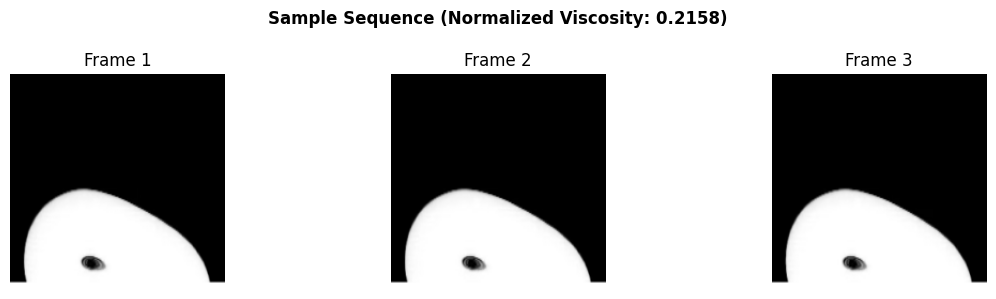

In [14]:
# Load and visualize a sample from MotherFolderDataset
if mother_dataset is not None and len(mother_dataset) > 0:
    sample_seq, normalized_viscosity = mother_dataset[0]
    
    print("📦 Sample from MotherFolderDataset:")
    print(f"  Sequence shape: {sample_seq.shape}")
    print(f"  Normalized viscosity: {normalized_viscosity.item():.4f}")
    print(f"  Actual viscosity: {normalized_viscosity.item() * mother_dataset._MaximumViscosityGetter:.2f}")
    
    # Visualize
    fig, axes = plt.subplots(1, sample_seq.shape[0], figsize=(12, 3))
    for i in range(sample_seq.shape[0]):
        frame = sample_seq[i, 0].numpy()
        axes[i].imshow(frame, cmap='gray')
        axes[i].set_title(f'Frame {i+1}')
        axes[i].axis('off')
    
    fig.suptitle(f'Sample Sequence (Normalized Viscosity: {normalized_viscosity.item():.4f})', 
                 fontweight='bold')
    plt.tight_layout()
    plt.show()
else:
    print("No data available")

### 6.2 Dataset Caching - Fast Loading! ⚡

Now let's use the caching system to save time on future loads.

In [16]:
# Save dataset cache
if mother_dataset is not None:
    cache_path = "Output/demo_dataset_cache.pkl"
    
    print("💾 Saving dataset cache...")
    mother_dataset.save_cache(cache_path)
    
    # Check file size
    cache_size_mb = os.path.getsize(cache_path) / (1024 * 1024)
    print(f"Cache saved: {cache_size_mb:.2f} MB")
else:
    print("⚠ No dataset to cache")

💾 Saving dataset cache...
Dataset cache saved to: Output/demo_dataset_cache.pkl
Cache saved: 2.48 MB


In [19]:
# Load from cache (much faster!)
if os.path.exists("Output/demo_dataset_cache.pkl"):
    print("⚡ Loading dataset from cache...")
    
    import time
    start = time.time()
    
    cached_dataset = MotherFolderDataset.load_cache("Output/demo_dataset_cache.pkl")
    
    elapsed = time.time() - start
    
    print(f"✓ Dataset loaded from cache in {elapsed:.2f} seconds")
    print(f"  Total samples: {len(cached_dataset)}")
    print(f"  Maximum viscosity: {cached_dataset._MaximumViscosityGetter:.2f}")
    
    # Verify it works the same
    sample_cached, visc_cached = cached_dataset[0]
    print(f"\n✅ Cache verification:")
    print(f"  Sample shape matches: {sample_cached.shape == sample_seq.shape}")
    print(f"  Viscosity matches: {abs(visc_cached.item() - normalized_viscosity.item()) < 1e-6}")
else:
    print("⚠ Cache file not found")

⚡ Loading dataset from cache...
Dataset loaded from cache: Output/demo_dataset_cache.pkl
Maximum viscosity in dataset: 20.670000076293945
✓ Dataset loaded from cache in 0.20 seconds
  Total samples: 6362
  Maximum viscosity: 20.67

✅ Cache verification:
  Sample shape matches: True
  Viscosity matches: True


---

## 7. Dataset Splitting

Split the dataset into train/validation/test sets for machine learning.

In [20]:
# Split dataset
if mother_dataset is not None:
    train_subset, val_subset, test_subset = split_dataset(
        mother_dataset,
        train_size=0.7,
        val_size=0.15,
        test_size=0.15,
        seed=42
    )
    
    print("📊 Dataset Split:")
    print(f"  Training samples: {len(train_subset)}")
    print(f"  Validation samples: {len(val_subset)}")
    print(f"  Test samples: {len(test_subset)}")
    print(f"  Total: {len(train_subset) + len(val_subset) + len(test_subset)}")
    
    # Verify split ratios
    total = len(mother_dataset)
    print(f"\n✓ Split ratios:")
    print(f"  Train: {len(train_subset)/total*100:.1f}%")
    print(f"  Val: {len(val_subset)/total*100:.1f}%")
    print(f"  Test: {len(test_subset)/total*100:.1f}%")
else:
    print("⚠ No dataset to split")

📊 Dataset Split:
  Training samples: 4453
  Validation samples: 954
  Test samples: 955
  Total: 6362

✓ Split ratios:
  Train: 70.0%
  Val: 15.0%
  Test: 15.0%


---

## 8. Complete Pipeline Visualization

Let's visualize the complete pipeline: original → reflection removal → with encoding.

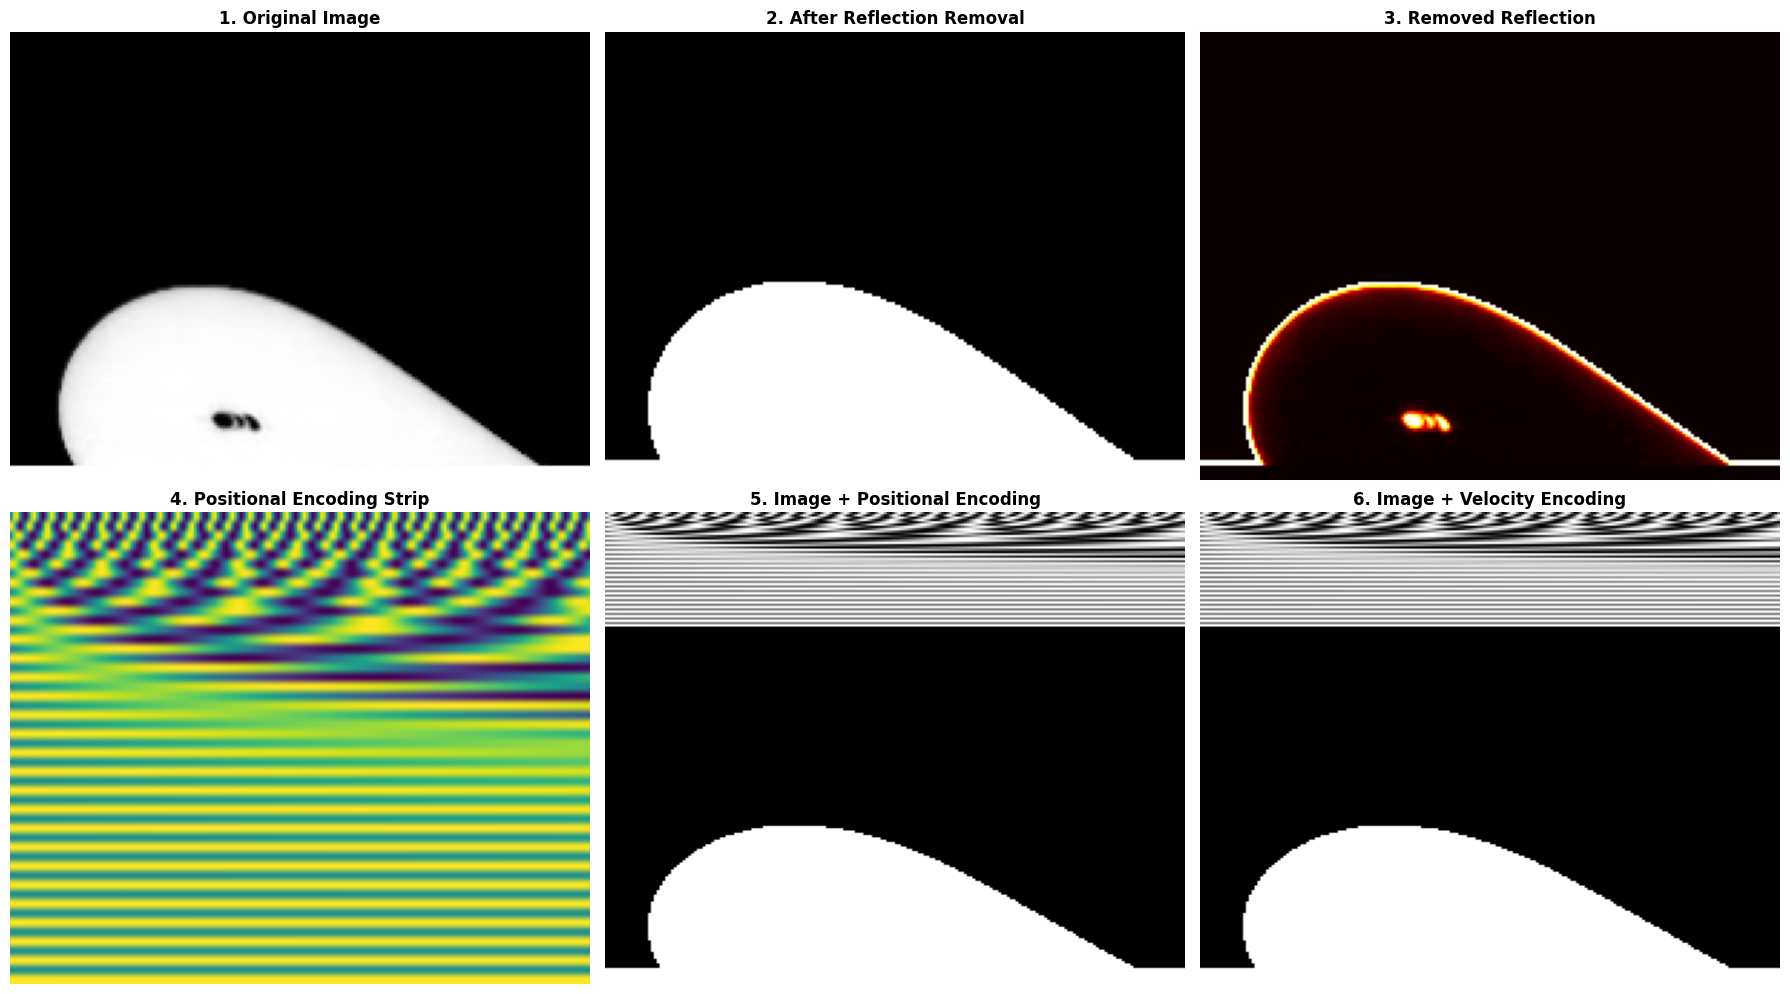

🎯 Complete Pipeline:
  1️⃣ Start with original droplet image
  2️⃣ Remove light source reflections
  3️⃣ Add positional or velocity encoding
  4️⃣ Feed to neural network for viscosity prediction


In [21]:
# Complete pipeline visualization
if len(sample_images) > 0:
    # Load original image
    img_orig = cv2.imread(sample_images[0], cv2.IMREAD_GRAYSCALE)
    
    # Apply reflection removal
    img_clean = LightSourceReflectionRemover(img_orig)
    
    # Create positional encoding strip (scaled to image width)
    pe_strip = PE_Generator(
        img_orig.shape[1],  # width
        Resize=True,
        velocity_encoding=False,
        positional_encoding=True,
        PE_height=50,
        default_image_size=(img_orig.shape[1], 50)
    )
    
    # Create velocity encoding strip
    ve_strip = PE_Generator(
        img_orig.shape[1],
        Resize=True,
        velocity_encoding=True,
        positional_encoding=False,
        PE_height=50,
        default_image_size=(img_orig.shape[1], 50)
    )
    
    # Concatenate image with encoding (simulating what DaughterFolderDataset does)
    img_with_pos = np.vstack([pe_strip, img_clean])
    img_with_vel = np.vstack([ve_strip, img_clean])
    
    # Visualize the complete pipeline
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    
    # Row 1: Processing steps
    axes[0, 0].imshow(img_orig, cmap='gray')
    axes[0, 0].set_title('1. Original Image', fontsize=12, fontweight='bold')
    axes[0, 0].axis('off')
    
    axes[0, 1].imshow(img_clean, cmap='gray')
    axes[0, 1].set_title('2. After Reflection Removal', fontsize=12, fontweight='bold')
    axes[0, 1].axis('off')
    
    axes[0, 2].imshow(cv2.absdiff(img_orig, img_clean), cmap='hot')
    axes[0, 2].set_title('3. Removed Reflection', fontsize=12, fontweight='bold')
    axes[0, 2].axis('off')
    
    # Row 2: With encodings
    axes[1, 0].imshow(pe_strip, cmap='viridis', aspect='auto')
    axes[1, 0].set_title('4. Positional Encoding Strip', fontsize=12, fontweight='bold')
    axes[1, 0].axis('off')
    
    axes[1, 1].imshow(img_with_pos, cmap='gray', aspect='auto')
    axes[1, 1].set_title('5. Image + Positional Encoding', fontsize=12, fontweight='bold')
    axes[1, 1].axis('off')
    
    axes[1, 2].imshow(img_with_vel, cmap='gray', aspect='auto')
    axes[1, 2].set_title('6. Image + Velocity Encoding', fontsize=12, fontweight='bold')
    axes[1, 2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print("🎯 Complete Pipeline:")
    print("  1️⃣ Start with original droplet image")
    print("  2️⃣ Remove light source reflections")
    print("  3️⃣ Add positional or velocity encoding")
    print("  4️⃣ Feed to neural network for viscosity prediction")
else:
    print("No sample images available")

---

## 9. Summary & Key Takeaways

### 🔑 Key Components

1. **LightSourceReflectionRemover**: Cleans images by removing unwanted reflections
2. **PE_Generator**: Creates positional or velocity encodings to add spatial/temporal context
3. **DaughterFolderDataset**: Handles individual experiment folders (one fluid, multiple repetitions)
4. **MotherFolderDataset**: Manages complete dataset with multiple fluids, balancing, and normalization

### ⚡ Performance Tips

- **Use caching**: Save and load dataset cache for 60x faster loading
- **Adjust stride**: Larger stride = fewer samples but faster training
- **Sequence length**: Balance between temporal context and memory usage

### 📁 Typical Workflow

```python
# 1. Load dataset splits
dicAddressesTrain, dicAddressesVal, dicAddressesTest = dicLoader(root="/path/to/data")

# 2. Create or load cached dataset
cache_path = "dataset_cache.pkl"
if os.path.exists(cache_path):
    dataset = MotherFolderDataset.load_cache(cache_path)
else:
    dataset = MotherFolderDataset(dicAddressesTrain, stride=5, sequence_length=3)
    dataset.save_cache(cache_path)

# 3. Split for training
train_set, val_set, test_set = split_dataset(dataset)

# 4. Use with PyTorch DataLoader
from torch.utils.data import DataLoader
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
```

### 📊 Configuration Options

All controlled via `config.yaml`:
- Image size and cropping
- Positional/velocity encoding settings
- Reflection removal on/off
- Super-resolution options

---

## 🎓 Additional Resources

- **CACHING_GUIDE.md**: Detailed caching documentation
- **QUICKSTART_CACHING.md**: Quick reference for caching
- **example_cache_usage.py**: Complete caching example script

---

*End of Demo Notebook*